In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
df_account = pd.read_csv('../challenge_data/account_dat.csv')
df_app = pd.read_csv('../challenge_data/app_dat.csv')
df_category = pd.read_csv('../challenge_data/category_ref.csv')
df_device = pd.read_csv('../challenge_data/device_ref.csv')
df_in_app = pd.read_csv('../challenge_data/in-app_dat.csv')
df_transaction = pd.read_csv('../challenge_data/transaction_dat.csv')

In [3]:
df_in_app_denorm = df_in_app.join(df_app.set_index('content_id'), on='parent_app_content_id')\
                .join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_in_app_denorm.head()

,parent_app_content_id,content_id,type,app_name,category_id,device_id,category_name,device_name
0,d2bde35599e0dae9,227227a77c59809b,consumable,lactantem prevailing,Z-1,3,Games,Both
1,d2bde35599e0dae9,41ac2362a2600185,consumable,lactantem prevailing,Z-1,3,Games,Both
2,d2bde35599e0dae9,64a8e16f030bb611,consumable,lactantem prevailing,Z-1,3,Games,Both
3,d2bde35599e0dae9,2c8ba424183afa7c,consumable,lactantem prevailing,Z-1,3,Games,Both
4,d2bde35599e0dae9,b4c42fa5cc420f7b,consumable,lactantem prevailing,Z-1,3,Games,Both


In [4]:
df_app_denorm = df_app.join(df_category.set_index('category_id'), on='category_id')\
                .join(df_device.set_index('device_id'), on='device_id')
df_app_denorm['type'] = 'download_only'
df_app_denorm.head()

,app_name,content_id,category_id,device_id,category_name,device_name,type
0,half-slouched having,22dfac9721b899cb,Y-8,3,Photos & Videos,Both,download_only
1,lift whale-ships,7c645810cd7f166e,M-7,3,Utilities,Both,download_only
2,mightily community,c495bcb878faffaa,Y-8,2,Photos & Videos,iPad,download_only
3,session: too--shall,4e683dcd461cdd22,Y-8,1,Photos & Videos,iPhone,download_only
4,That Zoology,6473dd29a2badbf1,Y-8,3,Photos & Videos,Both,download_only


In [5]:
cols_app = ['app_name', 'content_id', 'type', 'category_name', 'device_name']
df_app_all = pd.concat([df_in_app_denorm[cols_app],
                        df_app_denorm[cols_app]])
df_app_all

,app_name,content_id,type,category_name,device_name
0,lactantem prevailing,227227a77c59809b,consumable,Games,Both
1,lactantem prevailing,41ac2362a2600185,consumable,Games,Both
2,lactantem prevailing,64a8e16f030bb611,consumable,Games,Both
3,lactantem prevailing,2c8ba424183afa7c,consumable,Games,Both
4,lactantem prevailing,b4c42fa5cc420f7b,consumable,Games,Both
...,...,...,...,...,...
995,animals nights--do,71cc78b6addcdc63,download_only,Entertainment,Both
996,meeting-house? respond,42e45e59e6d3dcf1,download_only,Photos & Videos,Both
997,--SIBBALD'S occupation,d862535438d4314c,download_only,Utilities,Both
998,cylinders vain!,07d53efa8e531e15,download_only,Photos & Videos,Both


In [6]:
df_trn_denorm = df_transaction.join(df_device.set_index('device_id'), on='device_id')\
                    .join(df_account.set_index('acct_id'), on='acct_id', lsuffix='_transaction', rsuffix='_acct')

# fill accounts that cannot join to payment_type
df_trn_denorm['payment_type'] = df_trn_denorm['payment_type'].fillna('unknown')

In [7]:
df_wide = df_trn_denorm.join(df_app_all.drop(columns=['device_name'])\
                             .set_index('content_id'), on='content_id')

In [8]:
df_wide.head()

,create_dt_transaction,content_id,acct_id,price,device_id,device_name,create_dt_acct,payment_type,app_name,type,category_name
0,2016-08-28,b6cf4f33e7455df4,220574a7a6a71afa,11.99,1,iPhone,8/29/09,PMOF,events Bildad's,subscription,Utilities
1,2016-09-16,71ac3e9c38ddbbba,8551f69a5015ea6a,1.99,2,iPad,5/28/11,PMOF,swell questionably,consumable,Utilities
2,2016-08-15,776b851b916c33d1,7dedf309494a1966,0.99,2,iPad,11/15/09,PMOF,supperless--my Shipmates,consumable,Games
3,2016-06-17,7a47ca132a8dc695,7174a81c796dcf7e,1.99,2,iPad,3/1/09,PMOF,unwritten hungry,consumable,Games
4,2016-06-13,30581219bc952dbb,35aaf59d64a677e7,11.99,2,iPad,10/1/10,PMOF,Turning thanked,consumable,Entertainment


### Focus on Games Category

In [62]:
df_games = df_wide[(df_wide['category_name'] == 'Games') &
                   (df_wide['payment_type'] != 'unknown')]
df_games_n_acct = df_games[['app_name', 'acct_id']].groupby(by=['app_name']).nunique()\
                    .rename(columns={'acct_id':'n_acct'})
df_games_price = df_games[['app_name', 'price']].groupby(by=['app_name']).sum()\
                    .rename(columns={'price':'revenue'})
df_games_n_trn = df_games[['app_name', 'price']].groupby(by=['app_name']).count()\
                    .rename(columns={'price':'n_transactions'})

In [63]:
df_g_trn_acct = df_games_n_trn.join(df_games_n_acct, on='app_name')
df_g_trn_price = df_games_n_trn.join(df_games_price, on='app_name')
df_g_trn_price

,n_transactions,revenue
app_name,,
#NAME?,4893,57745.07
'vomited men,17892,322644.08
(KILLER)--Of surprised,5246,0.00
(SPERM scientific,2173,31667.27
--PARADISE then',5191,0.00
10% Spain,744,11152.56
15 Ahasuerus,6985,69457.15
18 genteel,5969,71274.31
AS-IS vagueness,21107,323134.93


<AxesSubplot:xlabel='n_transactions', ylabel='revenue'>

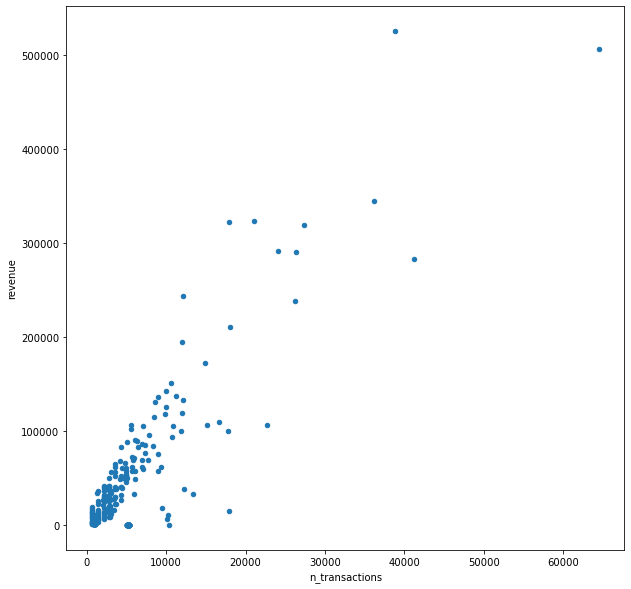

In [43]:
df_g_trn_price.plot.scatter(x='n_transactions', y='revenue', figsize=(10,10))

<AxesSubplot:xlabel='n_transactions', ylabel='n_acct'>

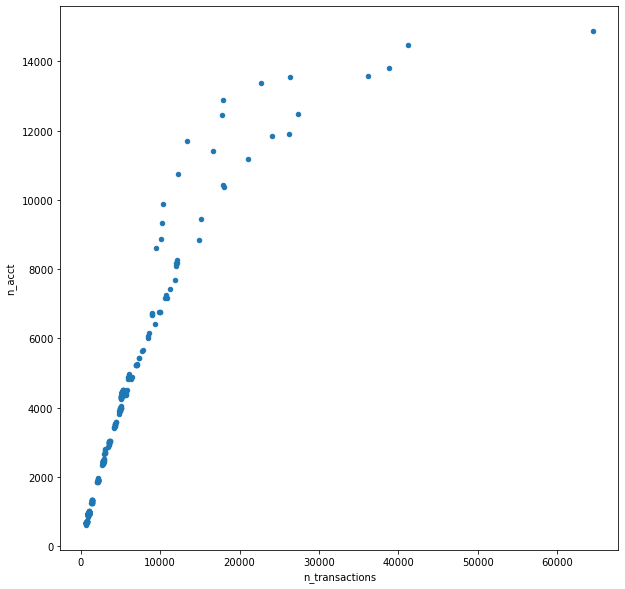

In [44]:
df_g_trn_acct.plot.scatter(x='n_transactions', y='n_acct', figsize=(10,10))

In [45]:
df_g_trn_acct.head()

,n_transactions,n_acct
app_name,,
#NAME?,4893,3903
'vomited men,17892,10418
(KILLER)--Of surprised,5246,4425
(SPERM scientific,2173,1899
--PARADISE then',5191,4386


### Are there game apps used by both PMOF and Free only accounts?

In [46]:
pd.set_option('display.max_rows', None)

In [51]:
df_g_app_pay_1 = df_games[['app_name', 'payment_type','acct_id']].groupby(by=['app_name', 'payment_type']).nunique()\
                    .rename(columns={'acct_id':'n_acct'})
df_g_app_pay_1.head(10)

,,n_acct
app_name,payment_type,
#NAME?,PMOF,3903
'vomited men,PMOF,10418
(KILLER)--Of surprised,Free only,4425
(SPERM scientific,PMOF,1899
--PARADISE then',Free only,4386
10% Spain,PMOF,710
15 Ahasuerus,PMOF,5234
18 genteel,PMOF,4893
AS-IS vagueness,PMOF,11195


In [52]:
df_g_app_pay_2 = df_games[['app_name', 'payment_type','acct_id']].groupby(by=['app_name', 'payment_type'])\
                    .count().rename(columns={'acct_id':'n_transactions'})
df_g_app_pay_2.head(10)

,,n_transactions
app_name,payment_type,
#NAME?,PMOF,4893
'vomited men,PMOF,17892
(KILLER)--Of surprised,Free only,5246
(SPERM scientific,PMOF,2173
--PARADISE then',Free only,5191
10% Spain,PMOF,744
15 Ahasuerus,PMOF,6985
18 genteel,PMOF,5969
AS-IS vagueness,PMOF,21107


In [55]:
df_g_app_pay_merged = df_g_app_pay_1.join(df_g_app_pay_2, on=['app_name', 'payment_type'])
df_g_app_pay_merged.head(5)

,,n_acct,n_transactions
app_name,payment_type,,
#NAME?,PMOF,3903,4893
'vomited men,PMOF,10418,17892
(KILLER)--Of surprised,Free only,4425,5246
(SPERM scientific,PMOF,1899,2173
--PARADISE then',Free only,4386,5191


<AxesSubplot:xlabel='n_transactions', ylabel='n_acct'>

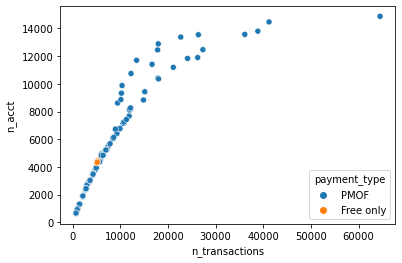

In [57]:
sns.scatterplot(data=df_g_app_pay_merged,
               x='n_transactions', y='n_acct', hue='payment_type')

<AxesSubplot:xlabel='n_transactions', ylabel='n_acct'>

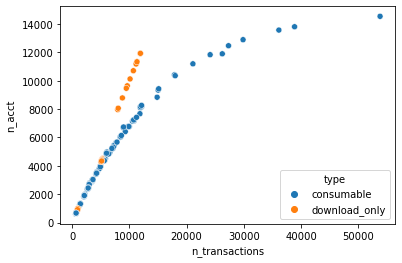

In [64]:
df_g_app_pay_1 = df_games[['app_name', 'type','acct_id']].groupby(by=['app_name', 'type']).nunique()\
                    .rename(columns={'acct_id':'n_acct'})
df_g_app_pay_2 = df_games[['app_name', 'type','acct_id']].groupby(by=['app_name', 'type'])\
                    .count().rename(columns={'acct_id':'n_transactions'})
df_g_app_pay_merged = df_g_app_pay_1.join(df_g_app_pay_2, on=['app_name', 'type'])

sns.scatterplot(data=df_g_app_pay_merged,
               x='n_transactions', y='n_acct', hue='type')

<AxesSubplot:xlabel='n_transactions', ylabel='revenue'>

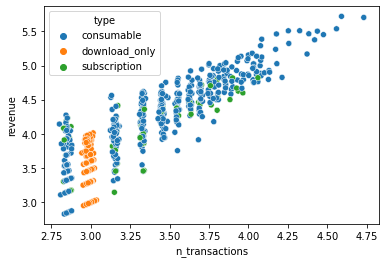

In [70]:
df_g_app_pay_1 = df_wide[['app_name', 'type','price']].groupby(by=['app_name', 'type']).sum().apply(np.log10)\
                    .rename(columns={'price':'revenue'})
df_g_app_pay_2 = df_wide[['app_name', 'type','acct_id']].groupby(by=['app_name', 'type'])\
                    .count().apply(np.log10).rename(columns={'acct_id':'n_transactions'})
df_g_app_pay_merged = df_g_app_pay_1.join(df_g_app_pay_2, on=['app_name', 'type'])

sns.scatterplot(data=df_g_app_pay_merged,
               x='n_transactions', y='revenue', hue='type')

<AxesSubplot:xlabel='n_transactions', ylabel='n_acct'>

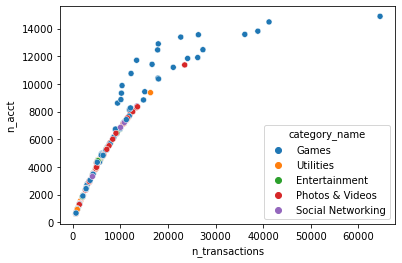

In [71]:
df_g_app_pay_1 = df_wide[['app_name', 'category_name','acct_id']].groupby(by=['app_name', 'category_name']).nunique()\
                    .rename(columns={'acct_id':'n_acct'})
df_g_app_pay_2 = df_wide[['app_name', 'category_name','acct_id']].groupby(by=['app_name', 'category_name'])\
                    .count().rename(columns={'acct_id':'n_transactions'})
df_g_app_pay_merged = df_g_app_pay_1.join(df_g_app_pay_2, on=['app_name', 'category_name'])

sns.scatterplot(data=df_g_app_pay_merged,
               x='n_transactions', y='n_acct', hue='category_name')

<AxesSubplot:xlabel='n_transactions', ylabel='revenue'>

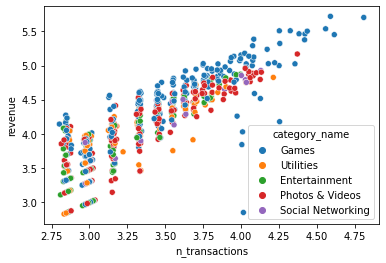

In [72]:
df_g_app_pay_1 = df_wide[['app_name', 'category_name','price']].groupby(by=['app_name', 'category_name']).sum().apply(np.log10)\
                    .rename(columns={'price':'revenue'})
df_g_app_pay_2 = df_wide[['app_name', 'category_name','acct_id']].groupby(by=['app_name', 'category_name'])\
                    .count().apply(np.log10).rename(columns={'acct_id':'n_transactions'})
df_g_app_pay_merged = df_g_app_pay_1.join(df_g_app_pay_2, on=['app_name', 'category_name'])

sns.scatterplot(data=df_g_app_pay_merged,
               x='n_transactions', y='revenue', hue='category_name')
